In [198]:
# Load Pandas library
import pandas as pd

#Load numpy library
import numpy as np

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

#Seaborn 
import seaborn as sb

#Magics for inline code.
%matplotlib inline

#Create Zillow Data Frame using Read_CSV
# read in the csv file
dfZillowData = pd.read_csv('/users/cmirwin/desktop/Smu Data Sets/Data Mining/ZillowData/Properties_2016.csv') 

dfTrainingData = pd.read_csv('/users/cmirwin/desktop/Smu Data Sets/Data Mining/ZillowData/train_2016.csv')


#Create new data set that contains both the data zillow and the data to train against
dfFullTestData = pd.merge(dfTrainingData, dfZillowData, on='parcelid', how='left')

#Remove 2.9 million records from memory
del dfZillowData


#Get the headers to ensure all columns are included.
dfFullTestData.head(10)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,1.0,NaN,NaN,4.0,4.0,NaN,1.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,7.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.26,NaN,NaN,6.059063e+13


In [200]:
#We can see that a number of the data columns have NaN values that were assigned during import
#we choose to replace those values with the median values for the variable.

#Create new columns with highest missing values as True/False.
#print(dfMajorityOfDataMissing)

dfFullTestData['hasbasement'] = dfFullTestData[['basementsqft']].where(dfFullTestData[['basementsqft']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hasdeck'] = dfFullTestData[['yardbuildingsqft26']].where(dfFullTestData[['yardbuildingsqft26']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hasfireplace'] = dfFullTestData[['fireplaceflag']].where(dfFullTestData[['fireplaceflag']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hashottuborspa'] = dfFullTestData[['hashottuborspa', 'pooltypeid2']].where(dfFullTestData[['hashottuborspa','pooltypeid2']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['haspatio'] = dfFullTestData[['yardbuildingsqft17']].where(dfFullTestData[['yardbuildingsqft17']].isnull(), 1).fillna(0).astype(int)

#Create Function for County Rename
def rename(row):
    if row['regionidcounty'] == 1286:
        val = 'Ventura County'
    elif row['regionidcounty'] == 3101:
        val = 'Los Angles County'
    else:
        val = 'Orange County'
    return val

dfFullTestData['countyname'] = dfFullTestData.apply(rename, axis=1)

print 'worked again'

worked again


In [201]:
#Create New data frame for everything
dfForModel = dfFullTestData.replace(to_replace='NaN',value= np.nan) 

#Get median values for based on original values
dfMedians = pd.DataFrame(dfFullTestData.median())

#Add Column Name to Medians DataFrame
dfMedians.columns = ['medianvalue']

#Create custom updates
dfColumns = pd.DataFrame(pd.Series([1.,0.,0.
                                    ,0.,0.,0.
                                    ,0.,0.,0.
                                    ,13.,5.,0.
                                    ,24.,0.,0.
                                    ,0.,0.,0.
                                    ,0.]
              , index=['numberofstories', 'bathroomcnt','bedroomcnt'
                      ,'fireplacecnt','fullbathcnt','garagecarcnt'
                      , 'poolcnt', 'roomcnt','unitcnt'
                      , 'heatingorsystemtypeid','airconditioningtypeid', 'garagetotalsqft'
                      , 'storytypeid', 'basementsqft', 'finishedsquarefeet13'
                      , 'finishedsquarefeet6','finishedsquarefeet15','finishedsquarefeet50'
                      , 'finishedfloor1squarefeet']))


#Set Column Name
dfColumns.columns = ['updatevalue']


#Create Merged Data set with values of both medians and custom
dfMerged = pd.concat([dfMedians, dfColumns], axis=1, join_axes=[dfMedians.index])

#Create new column of data that is custom values filled with median for any null
dfMerged['values'] = dfMerged['updatevalue'].fillna(dfMerged['medianvalue'])

#Apply median values to the overall data set
dfForModel = dfForModel.fillna(dfMerged['values'])

#Create smaller data set for descriptive stats section
dfDataForStats = dfForModel[['bathroomcnt',
                               'bedroomcnt',
                               'finishedfloor1squarefeet',
                               'calculatedfinishedsquarefeet',
                               'finishedsquarefeet15',
                               'lotsizesquarefeet',
                               'taxvaluedollarcnt',
                               'structuretaxvaluedollarcnt',
                               'landtaxvaluedollarcnt',
                               'taxamount']]

dfDataForStats.describe()


,bathroomcnt,bedroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet15,lotsizesquarefeet,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
count,90811.000000,90811.000000,90811.000000,90811.000000,90811.000000,9.081100e+04,9.081100e+04,9.081100e+04,9.081100e+04,90811.000000
mean,2.266020,3.013974,101.768618,1770.112310,93.409840,2.653193e+04,4.569938e+05,1.796083e+05,2.778305e+05,5975.374056
std,1.016413,1.176174,398.691906,922.408353,508.302478,1.145533e+05,5.533113e+05,2.081280e+05,3.993632e+05,6819.341095
min,0.000000,0.000000,0.000000,2.000000,0.000000,1.670000e+02,2.200000e+01,1.000000e+02,2.200000e+01,49.080000
25%,2.000000,2.000000,0.000000,1189.000000,0.000000,5.973000e+03,1.999335e+05,8.178800e+04,8.291150e+04,2884.155000
50%,2.000000,3.000000,0.000000,1540.000000,0.000000,7.200000e+03,3.428720e+05,1.320000e+05,1.929700e+05,4542.750000
75%,3.000000,4.000000,0.000000,2084.000000,0.000000,1.032850e+04,5.383630e+05,2.093270e+05,3.440000e+05,6881.865000
max,20.000000,16.000000,7625.000000,22741.000000,22741.000000,6.971010e+06,2.775000e+07,9.948100e+06,2.450000e+07,321936.090000


In [202]:
#Create dummy variables for all TypeId columns
#This section takes a long time due to the fact that we are creating 
#so many additional variables by 3 million records. 

#heatingorsystemtypeid
#Create dynamic Name
dummies = pd.get_dummies(dfForModel['heatingorsystemtypeid']).rename(columns=lambda x: 'HSTypeId_' + str(x))
#Join to Dataframe for Model
dfForModel = pd.concat([dfForModel, dummies], axis=1)

#Delete from model 
#dfForModel.drop(['heatingorsystemtypeid'], inplace=True, axis=1)

#Repeat of code above
#airconditioningtypeid
dummies = pd.get_dummies(dfForModel['airconditioningtypeid']).rename(columns=lambda x: 'ACTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['airconditioningtypeid'], inplace=True, axis=1)

#architecturalstyletypeid
dummies = pd.get_dummies(dfForModel['architecturalstyletypeid']).rename(columns=lambda x: 'ArchStyleTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['architecturalstyletypeid'], inplace=True, axis=1)

#decktypeid
dummies = pd.get_dummies(dfForModel['decktypeid']).rename(columns=lambda x: 'DeckTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['decktypeid'], inplace=True, axis=1)

#buildingclasstypeid
dummies = pd.get_dummies(dfForModel['buildingclasstypeid']).rename(columns=lambda x: 'BuildClassTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['buildingclasstypeid'], inplace=True, axis=1)

#typeconstructiontypeid
dummies = pd.get_dummies(dfForModel['typeconstructiontypeid']).rename(columns=lambda x: 'ConstructionTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['typeconstructiontypeid'], inplace=True, axis=1)

#buildingqualitytypeid
dummies = pd.get_dummies(dfForModel['buildingqualitytypeid']).rename(columns=lambda x: 'BuildingQualTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['buildingqualitytypeid'], inplace=True, axis=1)

#propertylandusetypeid
dummies = pd.get_dummies(dfForModel['propertylandusetypeid']).rename(columns=lambda x: 'LandUseTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['propertylandusetypeid'], inplace=True, axis=1)

#Create Function for County Rename
def garagecnt(row):
    if row['garagecarcnt'] > 0:
        val = 1
    else:
        val = 0
    return val

dfForModel['hasgarage'] = dfForModel.apply(garagecnt, axis=1)


#Find out what data types are in the Data set
dfDataTypes = pd.DataFrame(dfForModel)

#Create Numeric Only Dataframe
dfZillowDataNumeric = dfDataTypes.select_dtypes(['float64','int64'])
 
print 'complete again'

complete again


In [203]:
#Create Cross Validation object and Test and train values
# we want to predict if a house has a garage
if 'hasgarage' in dfZillowDataNumeric:
    
    #Get the values for each property
    actualValues = dfZillowDataNumeric['hasgarage'].values 
    
    # get rid of the hasgarage variable
    del dfZillowDataNumeric['hasgarage'] 

    #delete any variables that give the model the possible anwser
    del dfZillowDataNumeric['garagecarcnt']

    # Gather all values to use for prediction
    additionalVars = dfZillowDataNumeric.values    
    
# Create cross validation with KFolds object
num_cv_iterations = 3
#Create Cross Validation objects using folds
cv_object = KFold(n_splits=num_cv_iterations, random_state=None, shuffle=True)
cv_object.get_n_splits(additionalVars)

#Create training groups
X_train = additionalVars[train_indices]
y_train = actualValues[train_indices]
  
#Create Testing Groups
X_test = additionalVars[test_indices]
y_test = actualValues[test_indices]

print 'groups created'

groups created


In [204]:
#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
stdsclrObj.fit(X_train) # find scalings for each column that make this zero mean and unit std

# to transform new feature data
# apply to training
X_train_scaled = stdsclrObj.transform(X_train)

# apply those means and std to the test set (without snooping at the test set values)
X_test_scaled = stdsclrObj.transform(X_test) 

# Create a reusable logisitic regression object
# the variable C is for Cost, penalty is actually a lowercase L and has 
# other options l1 and l2
logRegression = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# Using the CV Object we iterate through the folds.
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_train_scaled,y_train)):
    logRegression.fit(X_train_scaled[train_indices],y_train[train_indices])  # train object
    y_hat = logRegression.predict(X_train_scaled[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num + 1," ====")
    print("accuracy", mt.accuracy_score(actualValues[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(actualValues[test_indices],y_hat))

('====Iteration', 1, ' ====')
('accuracy', 0.57707380796864793)
('confusion matrix\n', array([[1462,  681],
       [ 614,  305]]))
('====Iteration', 2, ' ====')
('accuracy', 0.58262573481384716)
('confusion matrix\n', array([[1461,  645],
       [ 633,  323]]))
('====Iteration', 3, ' ====')
('accuracy', 0.56713492322770331)
('confusion matrix\n', array([[1436,  698],
       [ 627,  300]]))


('index value of ', 0, 'Variable Name: ', 'regionidcounty', 'has weight of', -1.4201104538950939)
('index value of ', 1, 'Variable Name: ', 'structuretaxvaluedollarcnt', 'has weight of', -0.9005423717524994)
('index value of ', 2, 'Variable Name: ', 'finishedsquarefeet15', 'has weight of', -0.79989259275318092)
('index value of ', 3, 'Variable Name: ', 'calculatedbathnbr', 'has weight of', -0.63937346938176465)
('index value of ', 4, 'Variable Name: ', 'regionidcity', 'has weight of', -0.47636481931680108)
('index value of ', 5, 'Variable Name: ', 'lotsizesquarefeet', 'has weight of', -0.38946618663149501)
('index value of ', 6, 'Variable Name: ', 'LandUseTypeId_261.0', 'has weight of', -0.37762998389009472)
('index value of ', 7, 'Variable Name: ', 'roomcnt', 'has weight of', -0.3638833443466426)
('index value of ', 8, 'Variable Name: ', 'HSTypeId_2.0', 'has weight of', -0.31078448146381027)
('index value of ', 9, 'Variable Name: ', 'unitcnt', 'has weight of', -0.29813969432557058)
('

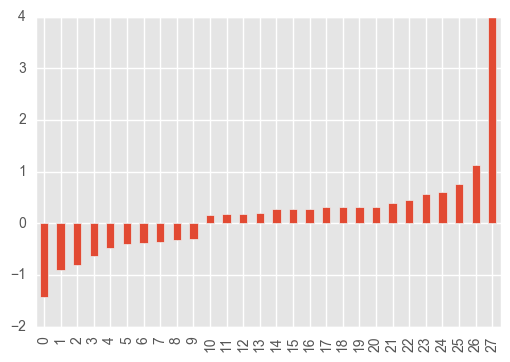

In [212]:
#Print results of last run.
# combine attributes
coefValues = zip(logReg.coef_.T,dfZillowDataNumeric.columns) 

# sort these attributes and spit them out
coefValues = pd.DataFrame(sorted(coefValues))

#zip_vars.columns = ['values', 'names']

#keep all columns from dataframe with absolute values of .25 
dfValuesGTfive = coefValues.loc[abs(coefValues[0]) > .15]

#Reset Index from removing data
dfValuesGTfive = dfValuesGTfive.reset_index(drop=True)

#Remove any duplicate values from multiple runs
dfValuesGTfive = dfValuesGTfive.drop_duplicates([1], keep='last')

# iterate over the Variable values
#Get weight values
weights = dfValuesGTfive[0] 
#Get Variable Names
variable_names = dfValuesGTfive[1]
#Get Index count
indexes = dfValuesGTfive.index
#Combined the data set and then print out results
for index, weight, name in zip(indexes, weights,variable_names):
    print('index value of ', index , 'Variable Name: ', name, 'has weight of', weight[0])
    
#Due to the large number of variables we choose an absolute value of .15 as a cut off
#Show all variables with an absolute value of greater than .15
plt.style.use('ggplot')
#The commented line below give the correct labels, but not the correct values.
#plotweights = pd.Series(dfValuesGTfive[0].astype(float), index=variable_names)
plotweights = pd.Series(dfValuesGTfive[0].astype(float))
plotweights.plot(kind='bar')
plt.show()